<a href="https://colab.research.google.com/github/Ronnypetson/titanic/blob/master/MNIST_Maromba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.optim import Adam

import pandas as pd
from sklearn.metrics import accuracy_score
import matplotlib.pylab as plt
import time
from IPython import display
from IPython.core.debugger import Pdb

def breakpoint():
    Pdb().set_trace()

device = "cuda:0" if torch.cuda.is_available() else "cpu"

%matplotlib inline

### Dataset

In [39]:
tr = ToTensor()

def _transform(x):
  return (tr(x) * 2.0 - 1.0).reshape(-1)

bsize = 32

MNIST_train_data = MNIST(
    'MNIST_root/',
    download=True,
    train=True,
    transform=_transform,
)
train_data_loader = torch.utils.data.DataLoader(
    MNIST_train_data,
    batch_size=bsize,
    shuffle=True,
    num_workers=1,
)

MNIST_test_data = MNIST(
    'MNIST_root_test/',
    download=True,
    train=False,
    transform=_transform,
)
test_data_loader = torch.utils.data.DataLoader(
    MNIST_test_data,
    batch_size=bsize,
    shuffle=True,
    num_workers=1,
)

In [58]:
def _posenc(shape, d=32):
  """
  3D Positional encodings (sin(row) + cos(col))
  """
  assert len(shape) == 2
  rows, cols = shape
  idx_sin = np.zeros((rows, d))
  idx_cos = np.zeros((cols, d))
  for idx in range(rows):
    _x = (np.arange(0, d) / d) * (4 * np.pi * (1 + idx / rows))
    idx_sin[idx] = np.sin(_x)
  for idx in range(cols):
    _x = (np.arange(0, d) / d) * (4 * np.pi * (1 + idx / cols))
    idx_cos[idx] = np.cos(_x)
  idx_sin = torch.from_numpy(idx_sin)
  idx_cos = torch.from_numpy(idx_cos)
  idx = (
      idx_sin.reshape((rows, 1, d)).repeat(1, cols, 1)
      + idx_cos.reshape((1, cols, d)).repeat(rows, 1, 1)
  )
  idx = idx.reshape(rows * cols, d) / 2.0
  return idx

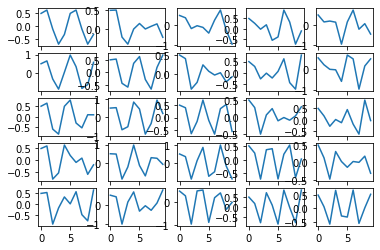

tensor([[ 2.3769,  0.7774,  0.8125,  1.2478,  1.0660],
        [ 0.8699,  0.7620,  0.6238,  0.1659,  0.3120],
        [-0.7855, -1.0667,  0.5680, -0.3445, -0.9564],
        [ 0.3041, -0.8704,  0.3097,  1.3053,  0.3289],
        [ 0.4005, -0.4459, -0.0239,  0.6071,  1.2509]], dtype=torch.float64)


In [59]:
rows, cols, d = 5, 5, 10
pos = _posenc((rows, cols), d).reshape(rows, cols, d)
fig, axs = plt.subplots(nrows=rows, ncols=cols, layout=None)
for row in range(rows):
  for col in range(cols):
    axs[row][col].plot(range(d), pos[row, col].numpy())
plt.show()
print(pos[0] @ pos[1].T)

(<matplotlib.image.AxesImage at 0x7fc2a2fdf400>, 5)

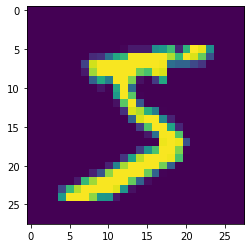

In [8]:
x, y = MNIST_train_data[0]
plt.imshow(np.array(x.reshape(28, 28))), y

### Classe Tensor Maromba

In [10]:
class MTensor:
  def __init__(
      self,
      values: torch.Tensor,
      indices: torch.Tensor,
      indexer: nn.Module,
    ):
    assert values.shape == indices.shape[:-1]
    self.data = values
    self.idx = indices
    self.indexer = indexer

  def _gbmd(self, u, v, idxu, idxv) -> torch.Tensor:
    """
    'General Batch Maromba Dot'
    Shorter implementation for the 'batch maromba dot' operation.
    u: M x d_u
    v: N x d_v
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u = u.shape
    n, d_v = v.shape
    d_idx = idxu.shape[-1]
    assert (m, d_u, d_idx) == idxu.shape
    assert (n, d_v, d_idx) == idxv.shape
    # uidxu: M x d_idx
    # vidxv: N x d_idx
    uidxu = torch.bmm(u.reshape(m, 1, d_u), idxu).squeeze(1)
    vidxv = torch.bmm(v.reshape(n, 1, d_v), idxv).squeeze(1)
    dot = uidxu @ vidxv.T
    return dot

  def _xor_idx(self, idxu, idxv):
    """
    idxu: M x d_u x d_idx
    idxv: N x d_v x d_idx
    """
    m, d_u, d_idx = idxu.shape
    n, d_v, _ = idxv.shape
    assert d_idx == idxv.shape[-1]
    # idxu: (M * d_u) x d_idx x 1
    # idxv: (N * d_v) x d_idx x 1
    idxu = idxu.reshape(m * d_u, d_idx, 1)
    idxv = idxv.reshape(n * d_v, d_idx, 1)
    # siiT: M x d_idx x d_idx
    # sjjT: N x d_idx x d_idx
    siiT = torch.bmm(idxu, idxu.permute(0, 2, 1))
    siiT = siiT.reshape(m, d_u, d_idx, d_idx).sum(dim=1)
    sjjT = torch.bmm(idxv, idxv.permute(0, 2, 1))
    sjjT = sjjT.reshape(n, d_v, d_idx, d_idx).sum(dim=1) ###
    # siiT: (M * N) x d_idx x d_idx
    # sjjT: (M * N) x d_idx x d_idx
    siiT = siiT.unsqueeze(1).repeat(1, n, 1, 1).reshape(m * n, d_idx, d_idx)
    sjjT = sjjT.unsqueeze(0).repeat(m, 1, 1, 1).reshape(m * n, d_idx, d_idx)
    # si: (M * N) x d_idx x 1
    # sj: (M * N) x d_idx x 1
    si = idxu.reshape(m, d_u, d_idx).sum(dim=1).unsqueeze(1)
    si = si.repeat(1, n, 1).reshape(m * n, d_idx, 1)
    sj = idxv.reshape(n, d_v, d_idx).sum(dim=1).unsqueeze(0)
    sj = sj.repeat(m, 1, 1).reshape(m * n, d_idx, 1)
    diag_siiT_sjjT = torch.diagonal(torch.bmm(siiT, sjjT), dim1=1, dim2=2)
    diag_siiT_sjjT = diag_siiT_sjjT.unsqueeze(-1)
    xor_idx = torch.bmm(siiT, sj) + torch.bmm(sjjT, si) - 2 * diag_siiT_sjjT
    xor_idx = xor_idx.reshape(m, n, d_idx) / d_u
    return xor_idx

  def __matmul__(self, b):
    apre = self.data.shape[:-1]
    bpre = b.data.shape[:-1]
    d_idx = self.idx.shape[-1]
    assert d_idx == b.idx.shape[-1]
    aidx = self.idx.reshape(*((-1,) + self.idx.shape[-2:]))
    bidx = b.idx.reshape(*((-1,) + b.idx.shape[-2:]))
    mdot = self._gbmd(
        self.data.reshape(-1, self.data.shape[-1]),
        b.data.reshape(-1, b.data.shape[-1]),
        aidx,
        bidx
    )
    mdot = mdot.reshape(apre + bpre)
    midx = self._xor_idx(aidx, bidx)
    midx = midx.reshape(apre + bpre + (d_idx,))
    mans = MTensor(mdot, midx, self.indexer)
    return mans

### Classe do Módulo Treinável

In [ ]:
class MModule(nn.Module):
  def __init__(self, n_params=600, idx_dim=32, out_dim=32, k=32, device="cpu"):
    super().__init__()
    self.idx_dim = idx_dim
    self.out_dim = out_dim
    self.k = k
    self.W = nn.Parameter(torch.randn((1, n_params), device=device))
    self.W_idx = nn.Parameter(torch.randn((1, n_params, idx_dim), device=device))

  def forward(self, x: MTensor):
    """
    x: (N x in_dim, N x in_dim x idx_dim)
    """
    # matches: N x in_dim x k
    matches = torch.topk(x.idx @ self.W_idx[0].T, self.k, dim=-1)

### Função de Custo

In [11]:
def maromba_loss(y_true, y_pred, true_index, pred_index, debug=False):
  """
  y_true: N x d_out
  y_pred: N x d_out
  true_index: N x d_out x d_index
  pred_index: N x d_out x d_index
  """
  n, d_out = y_true.shape
  assert y_true.shape == y_pred.shape
  assert true_index.shape == pred_index.shape
  # index_match: N x d_out x d_out
  index_match = torch.bmm(pred_index, true_index.permute(0, 2, 1))
  # y_true_match: N x 1 x d_out
  # y_pred_match: N x 1 x d_out
  y_true_match = torch.bmm(y_true.unsqueeze(1), index_match.permute(0, 2, 1))
  y_pred_match = torch.bmm(y_pred.unsqueeze(1), index_match)
  huber = nn.HuberLoss()
  match_loss_lr = huber(y_pred, y_true_match.squeeze(1))
  match_loss_rl = huber(y_true, y_pred_match.squeeze(1))
  loss = match_loss_lr + match_loss_rl
  return loss

### -------